In [1]:
import pandas as pd
import numpy as np

from gensim.utils import simple_preprocess

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import spacy #pos# should i also try to do tokenization?


from sklearn.feature_extraction.text import CountVectorizer #bow

import gensim
from gensim.models import Word2Vec, KeyedVectors


from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MultiLabelBinarizer



In [2]:
df=pd.read_csv('cleaned_tmdb_movies.csv')
df.head(1)

,title,overview,genre_ids,genre_names
0,Zootopia 2,After cracking the biggest case in Zootopia's ...,"16,35,12,10751,9648","Animation,Comedy,Adventure,Family,Mystery"


In [3]:
#simple preprocesing
df['overview']=df['overview'].astype(str).apply(lambda x: simple_preprocess(x, min_len=2))
df['overview'].head(1)

0    [after, cracking, the, biggest, case, in, zoot...
Name: overview, dtype: object

In [4]:
#pos tagging
#POS taggers are designed to work on tokenized words, not on raw text.
nlp=spacy.load('en_core_web_sm')
df['overview']=df['overview'].astype(str)
#df['overview']=(df['overview']).apply(nlp)#replace this sentence with df
df['doc'] = df['overview'].apply(nlp)




In [5]:
spacy.explain('X')

'other'

In [ ]:
[print(token.text, token.pos_, token.tag_) for token in df['doc'][0]]

In [11]:
len(df['doc'])

9980

In [12]:
#keep only pos that will be useful for genre classification
KEEP_POS = {"NOUN", "VERB", "ADJ"}

df['tokens'] = df['doc'].apply(
    lambda doc: [
        token.text.lower()
        for token in doc
        if token.pos_ in KEEP_POS and token.is_alpha
    ]
)




In [13]:
len(df['tokens'][0])

34

In [14]:
#feature engineering
#w2v: shallow-ANN>>learns embedding of words 

tokenized_corpus = df['tokens'].tolist()
model = Word2Vec(sentences=tokenized_corpus, vector_size=300,
    window=10,
    min_count=2,
    sg=1  # skip-gram >>for sementic
)


In [15]:


#len(model.wv) #vocabulary size
#print(model.wv['good'] )#to get vector representation
print(model.wv.similarity("good", "bad")) #cosine similarity between two words

#apply pca to get representation

0.9152132


In [16]:
print(model.wv.most_similar("best") )#most similar words to king


[('close', 0.7633490562438965), ('childhood', 0.7389347553253174), ('martin', 0.7227896451950073), ('invited', 0.7151154279708862), ('friend', 0.7055185437202454), ('party', 0.7046118974685669), ('celebrate', 0.7018541693687439), ('new', 0.6981527209281921), ('imaginary', 0.6973912715911865), ('berk', 0.6909066438674927)]


In [17]:
print(model.get_latest_training_loss())


0.0


In [18]:
print(model.wv.get_normed_vectors().shape)
#print(model.wv.get_normed_vectors())
print(model.wv.index_to_key)
#output shape is  vocab size, num of features

(14150, 300)
['life', 'new', 'young', 'world', 'family', 'man', 'love', 'film', 'old', 'find', 'story', 'time', 'years', 'woman', 'father', 'get', 'has', 'friends', 'finds', 'year', 'other', 'first', 'home', 'war', 'wife', 'help', 'more', 'town', 'own', 'daughter', 'mother', 'son', 'most', 'girl', 'lives', 'takes', 'city', 'take', 'friend', 'day', 'way', 'group', 'people', 'becomes', 'school', 'death', 'make', 'documentary', 'mysterious', 'work', 'set', 'husband', 'have', 'become', 'meets', 'gets', 'murder', 'save', 'go', 'best', 'high', 'police', 'last', 'live', 'begins', 'small', 'past', 'former', 'secret', 'men', 'team', 'true', 'night', 'tries', 'children', 'order', 'wants', 'decides', 'goes', 'series', 'women', 'fight', 'falls', 'discovers', 'money', 'forced', 'journey', 'mission', 'end', 'living', 'little', 'turns', 'relationship', 'comes', 'real', 'evil', 'history', 'job', 'couple', 'brother', 'movie', 'named', 'crime', 'come', 'left', 'child', 'face', 'days', 'same', 'beautiful

In [19]:
#convert words to fixed-length numerical feature vector 

def document_vector(tokens):
    vectors = [model.wv[word] for word in tokens if word in model.wv]

    if len(vectors) == 0:
        return np.zeros(model.vector_size)

    return np.mean(vectors, axis=0)

'''
X = np.vstack([
    document_vector(tokens)
    for tokens in df['tokens']
])
'''

df['X'] = df['tokens'].apply(document_vector)

X = np.vstack(df['X'].values)

'''
Word2Vec gives vectors for WORDS, not DOCUMENTS
Vector for entire document

Word2Vec (word-level)	1 word → 300 dims	: not used in ml
Avg Word2Vec (doc-level)	doc → 300 dims	: used in ml

'''

'\nWord2Vec gives vectors for WORDS, not DOCUMENTS\nVector for entire document\n\nWord2Vec (word-level)\t1 word → 300 dims\t: not used in ml\nAvg Word2Vec (doc-level)\tdoc → 300 dims\t: used in ml\n\n'

In [20]:
X[1].shape, X[0].shape, X.shape

((300,), (300,), (9980, 300))

In [21]:
# Ensure `genre_names` has no NaNs and convert to lists
# Replace NaNs with empty string so split is safe
df['genre_names'] = df['genre_names'].fillna('')
# Convert to lists of genres (empty list for missing); strip whitespace and ignore empty labels
y_lists = df['genre_names'].apply(lambda x: [g.strip() for g in x.split(',') if g.strip()] if x else [])

In [22]:
'''#dont do label encoding/ because genre are multiple
#perform multilabel binarization
mlb = MultiLabelBinarizer()
y= df['genre_names'].apply(lambda x: x.split(','))
#y = mlb.fit_transform(df['genre_names'])
'''

"#dont do label encoding/ because genre are multiple\n#perform multilabel binarization\nmlb = MultiLabelBinarizer()\ny= df['genre_names'].apply(lambda x: x.split(','))\n#y = mlb.fit_transform(df['genre_names'])\n"

In [23]:
#dont do label encoding/ because genre are multiple
#perform multilabel binarization

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y_lists)

from scipy import sparse
y_sparse = sparse.csr_matrix(y)

print("num classes:", len(mlb.classes_), "y shape:", y.shape)
print("sample classes:", mlb.classes_[:10])

num classes: 19 y shape: (9980, 19)
sample classes: ['Action' 'Adventure' 'Animation' 'Comedy' 'Crime' 'Documentary' 'Drama'
 'Family' 'Fantasy' 'History']


In [24]:
y_sparse

<Compressed Sparse Row sparse matrix of dtype 'int32'
	with 20952 stored elements and shape (9980, 19)>

In [25]:
df['genre_names'].head(1)

0    Animation,Comedy,Adventure,Family,Mystery
Name: genre_names, dtype: object

In [26]:
print(y[0])

[0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0]


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=mlb.classes_))

                 precision    recall  f1-score   support

         Action       0.69      0.33      0.45       323
      Adventure       0.47      0.12      0.19       255
      Animation       0.36      0.02      0.04       169
         Comedy       0.63      0.30      0.40       652
          Crime       0.59      0.18      0.27       199
    Documentary       0.72      0.45      0.55       222
          Drama       0.60      0.34      0.43       701
         Family       0.50      0.07      0.12       181
        Fantasy       0.62      0.03      0.06       157
        History       0.50      0.01      0.02        85
         Horror       1.00      0.01      0.03       137
          Music       0.44      0.07      0.12        96
        Mystery       0.00      0.00      0.00       112
        Romance       0.57      0.10      0.17       232
Science Fiction       0.29      0.04      0.07       117
       TV Movie       0.00      0.00      0.00       147
       Thriller       0.60    

c:\Users\Aliza Momin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Aliza Momin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Aliza Momin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _wa

In [28]:
#print acc of test
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.1157


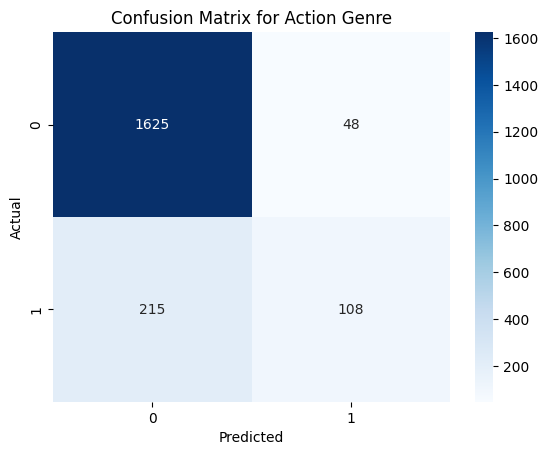

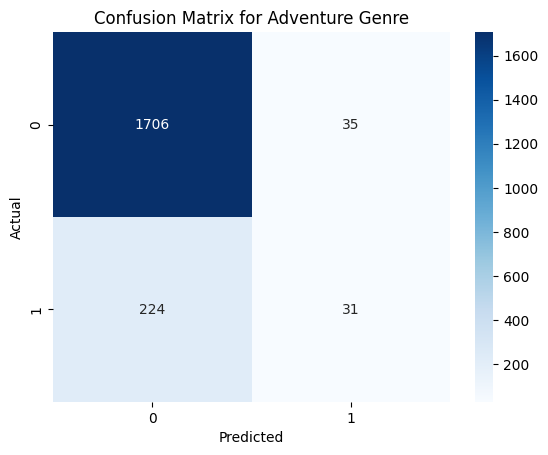

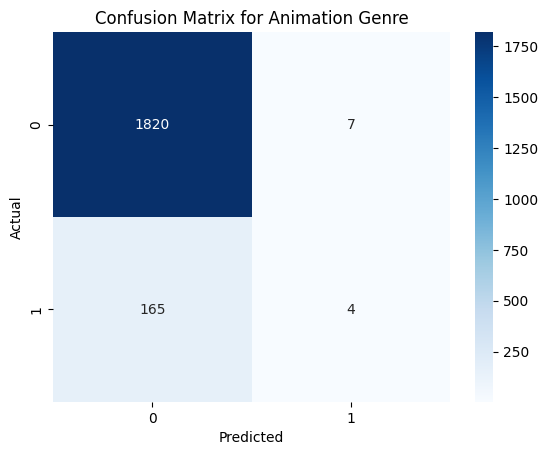

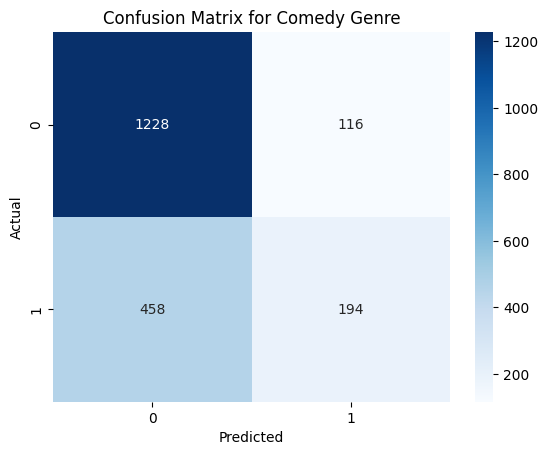

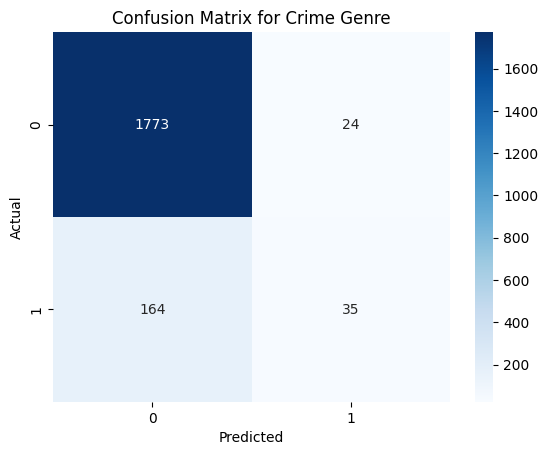

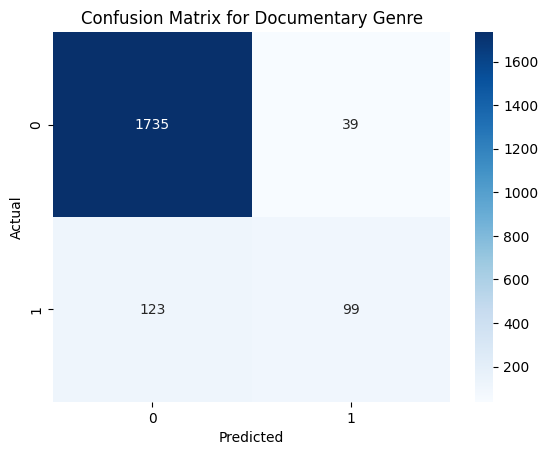

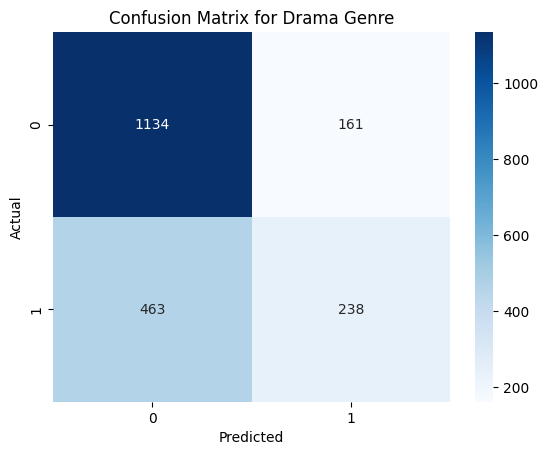

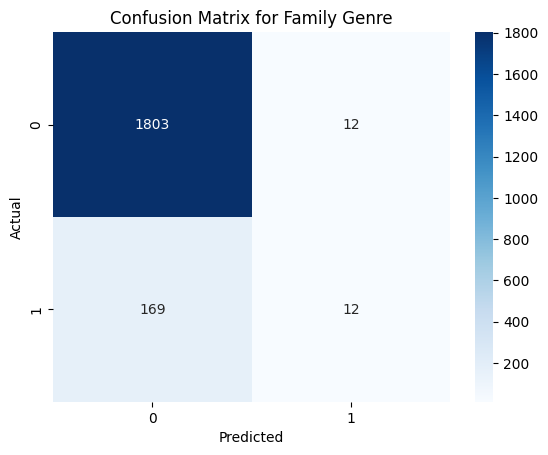

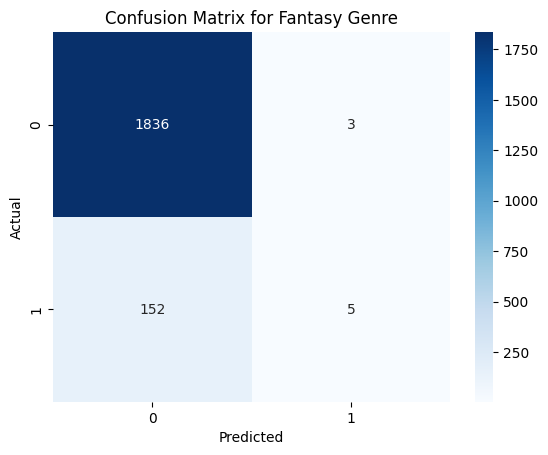

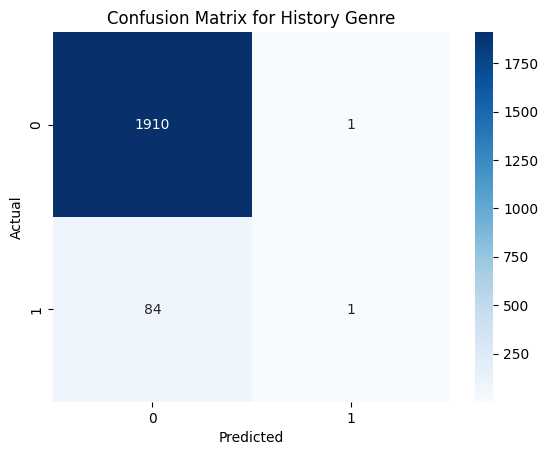

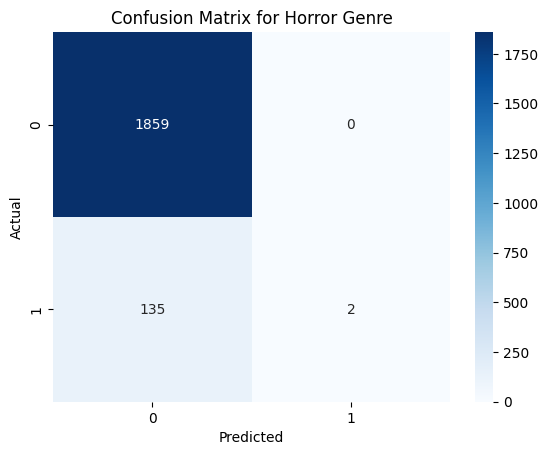

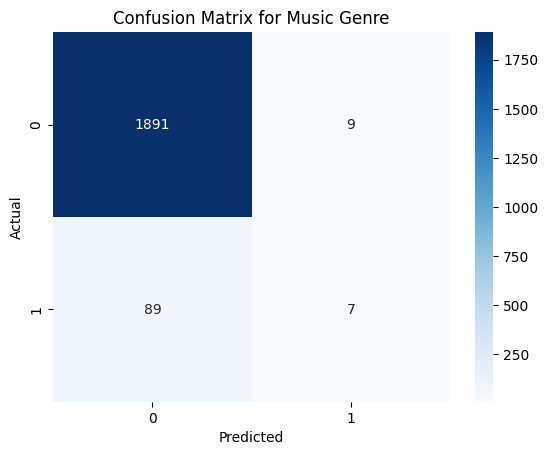

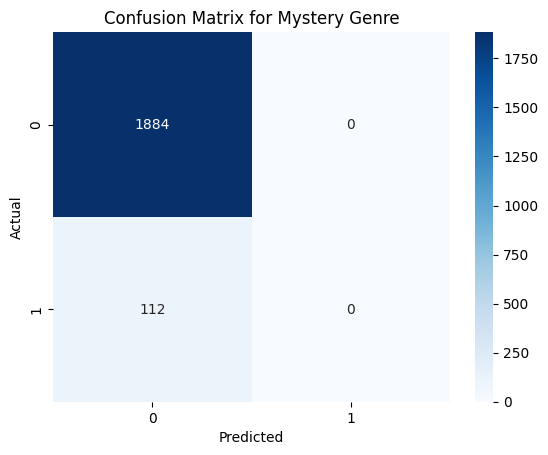

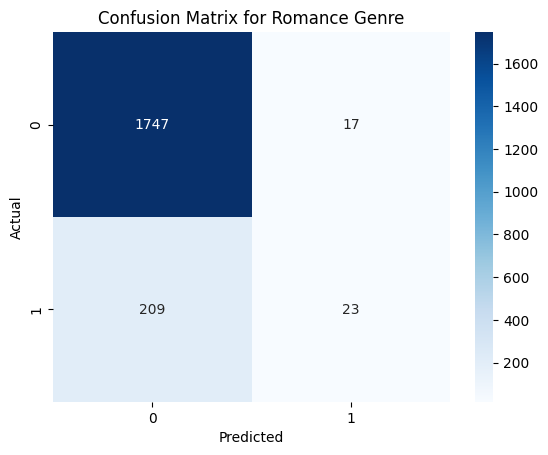

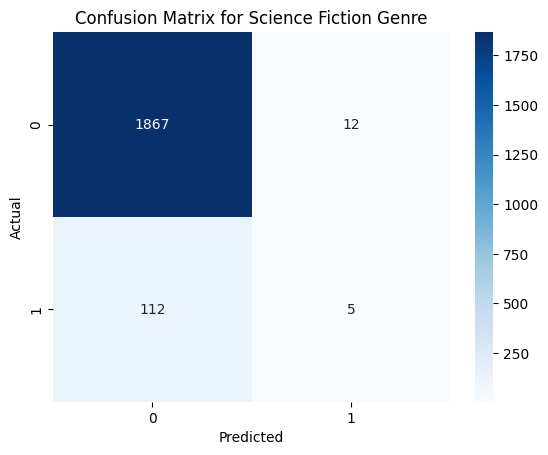

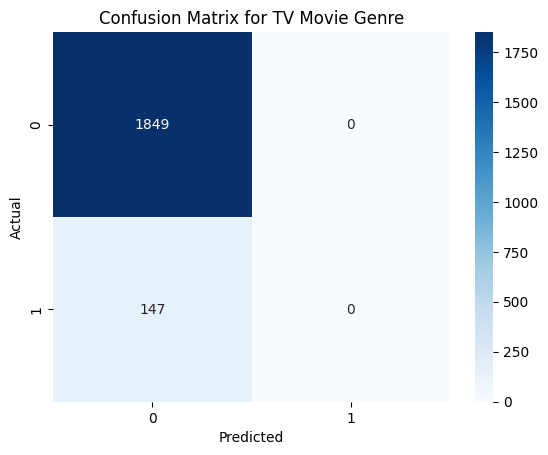

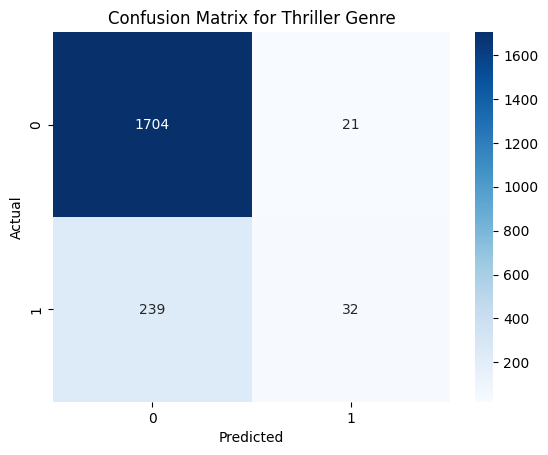

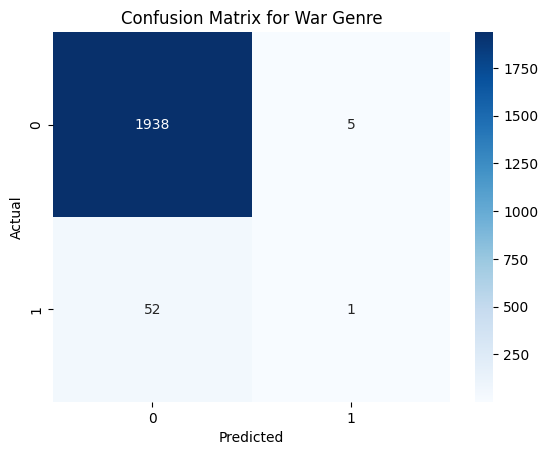

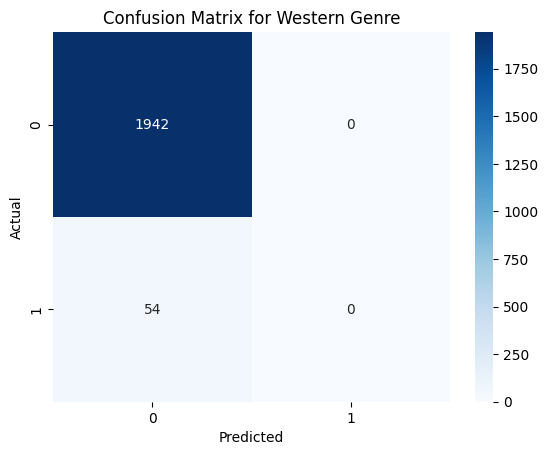

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


for y in mlb.classes_:
    idx = list(mlb.classes_).index(y)

    cm = confusion_matrix(y_test[:, idx], y_pred[:, idx])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {y} Genre")
    plt.show()
